# run_car

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
dyn_plot = True
class DynamicUpdate():
    def on_launch(self):
        #Set up plot
        self.figure, self.ax = plt.subplots()
        self.lines, = self.ax.plot([],[])
        #Autoscale on unknown axis and known lims on the other
        self.ax.set_autoscaley_on(True)
        self.ax.set_autoscalex_on(True)
        #Other stuff
        self.ax.grid()

    def on_running(self, xdata, ydata):
        #Update data (with the new _and_ the old points)
        self.lines.set_xdata(xdata)
        self.lines.set_ydata(ydata)
        #Need both of these in order to rescale
        self.ax.relim()
        self.ax.autoscale_view()
        #We need to draw *and* flush
        self.figure.canvas.draw()
        self.figure.canvas.flush_events()

In [2]:
import datetime
import numpy as np
import random

In [3]:
from cars.world import SimpleCarWorld
from cars.agent import SimpleCarAgent
from cars.physics import SimplePhysics
from cars.track import generate_map

In [4]:
from tqdm import tqdm_notebook

In [5]:
from functools import reduce

In [6]:
import pandas as pd

In [7]:
def create_map(seed, agent):
    np.random.seed(seed)
    random.seed(seed)
    m = generate_map(8, 5, 3, 3)
    w = SimpleCarWorld([agent], m, SimplePhysics, None, timedelta=0.2)
    return w

In [8]:
import seaborn as sns

# Параметры

In [9]:
map_seeds = [3, 13, 23]

In [10]:
# За сколько шагов модель начинает учитывать вознаграждение
map_seed = map_seeds[0]

# Нарабатываем данные, учимся и оцениваемся

In [11]:
log_list = []

In [12]:
def norm_y(y):
    return y / 5.0

In [13]:
def mine_data(agent, action_trainer_params,
              clear_history, map_seed, steps,
              epochs, mini_batch_size, eta, reward_shift, alpha):
    agent.action_trainer.set_params(**action_trainer_params)
    if clear_history:
        agent.clear_history()
    
    # сбрасываем статистику
    agent.action_trainer.reset_steps()
    
    #mine data
    w = create_map(seed=map_seed, agent=agent)
    w.run(steps=tqdm_notebook(range(steps), desc="train", leave=False), visual=False, save=False)

    steps_str = "total: {:d}, bad: {:.4f}, good: {:.4f}, diff: {:.4f}, other: {:.4f}".format(
        agent.action_trainer.steps[0],
        agent.action_trainer.steps[1] / agent.action_trainer.steps[0],
        agent.action_trainer.steps[2] / agent.action_trainer.steps[0],
        agent.action_trainer.steps[3] / agent.action_trainer.steps[0],
        1 - sum(agent.action_trainer.steps[1:]) / agent.action_trainer.steps[0])
    
    # prepare train data
    X_train = np.concatenate([agent.sensor_data_history, agent.chosen_actions_history], axis=1)
    y_train = np.array(agent.reward_history)
    # сглаживаем пики, чтобы сеть небольшая сеть могла дать адекватное предсказание
    mean_train_revard = y_train.mean()
    y_train = norm_y(y_train)
    
    y_train = np.pad(y_train, (0, 2 * reward_shift), mode="constant")
    y_train = reduce(lambda a, b: a + b, [y_train[i:(-2 * reward_shift + i)] * (alpha ** i)
                                      for i in range(reward_shift)])

    #train NN
    train_data = [(x[:, np.newaxis], y) for x, y in zip(X_train, y_train)]
    train_rmse_before = agent.neural_net.evaluate(X_train.T, y_train)
    next(agent.neural_net.SGD(training_data=train_data,
                         epochs=tqdm_notebook(range(epochs), desc="SGD", leave=False),
                         mini_batch_size=mini_batch_size,
                         eta=eta))
    train_rmse_after = agent.neural_net.evaluate(X_train.T, y_train)

    collisions = sum((1 if x < 0 and  0 < len(agent.reward_history) - i < steps else 0 
                      for i, x in enumerate(agent.reward_history))) / steps
    
    # evaluate
    w = create_map(seed=map_seed, agent=agent)
    mean_test_reward = w.evaluate_agent(agent, steps=tqdm_notebook(range(800), desc="test", leave=False), visual=False)
    
    
    log_message = f"""map_seed = {map_seed}
train_rmse_before = {train_rmse_before:.9f}, train_rmse_after = {train_rmse_after:.9f}, 
mean_train_revard = {mean_train_revard:.3f}, mean_test_reward  = {mean_test_reward:.3f},
steps = {steps_str},
collisions = {collisions}"""

    log_list.append(log_message)
    if not dyn_plot:
        chart_count = agent.neural_net.num_layers
        plt.figure(figsize=(5 * chart_count, 2))
        for l in range(chart_count - 1):
            plt.subplot(1, chart_count, l+1)
            ax = sns.heatmap(agent.neural_net.weights[l])

        plt.subplot(1, chart_count, chart_count)    
        plt.text(0.05, 0.95, log_message, size=12, ha='left', va='top', family='monospace')

        plt.show()
    else:
        print(log_message)

In [14]:
from learning_algorithms.network import Network

In [15]:
kvparams = {
    "clear_history": False,
    "map_seed": map_seed,
    "epochs": 100,
    "mini_batch_size": 50,
    "eta": 0.5,
    "reward_shift": 3,
    "alpha": 0.7
}

act_trainer = {
    "low": 0.0,
    "high": 0.0,
    "random_default": 0.8,
    "random_bad": 0.8,
    "random_good": 0.8,
    "random_diff": 0.8,
    "bad_choice_p": 0.01
}

random.seed(42)
np.random.seed(42)
agent1 = SimpleCarAgent(name="Ivan", history_data=50000)
agent1.neural_net = Network([9, 18, 8, 1], output_function=lambda x: x, output_derivative=lambda x: 1)

In [16]:
print("\n\n".join(log_list) + "\n----\n")
for _ in tqdm_notebook(range(1), desc="main"):
    mine_data(agent1, act_trainer, steps=4000, **kvparams)


----

map_seed = 3
train_rmse_before = 1.246787131, train_rmse_after = 0.204046886, 
mean_train_revard = -0.422, mean_test_reward  = -0.617,
steps = total: 4000, bad: 0.6052, good: 0.2655, diff: 0.1690, other: -0.0397,
collisions = 0.04475



In [17]:
y_train_setting = norm_y(np.array(agent1.reward_history))

act_trainer["low"] = -0.4
act_trainer["high"] = -0.2

act_trainer["random_default"] = 0.01
act_trainer["random_bad"] = 0.80
act_trainer["random_good"] = 0.01
act_trainer["random_diff"] = 0.01

act_trainer["bad_choice_p"] = 0.01

In [18]:
print("\n\n".join(log_list) + "\n----\n")

for _ in tqdm_notebook(range(5), desc="main"):
    mine_data(agent1, act_trainer, steps=2000, **kvparams)
    print("")

map_seed = 3
train_rmse_before = 1.246787131, train_rmse_after = 0.204046886, 
mean_train_revard = -0.422, mean_test_reward  = -0.617,
steps = total: 4000, bad: 0.6052, good: 0.2655, diff: 0.1690, other: -0.0397,
collisions = 0.04475
----

map_seed = 3
train_rmse_before = 0.338561515, train_rmse_after = 0.235725001, 
mean_train_revard = -0.473, mean_test_reward  = -1.264,
steps = total: 2000, bad: 0.0710, good: 0.9165, diff: 0.0015, other: 0.0110,
collisions = 0.02

map_seed = 3
train_rmse_before = 0.380884422, train_rmse_after = 0.194057931, 
mean_train_revard = -0.602, mean_test_reward  = -4.939,
steps = total: 2000, bad: 0.0630, good: 0.9090, diff: 0.0000, other: 0.0280,
collisions = 0.1365

map_seed = 3
train_rmse_before = 0.650698713, train_rmse_after = 0.236153769, 
mean_train_revard = -0.930, mean_test_reward  = -0.273,
steps = total: 2000, bad: 0.0320, good: 0.9355, diff: 0.0025, other: 0.0300,
collisions = 0.2655

map_seed = 3
train_rmse_before = 0.233838440, train_rmse_after 

In [19]:
kvparams["eta"] = 0.1
act_trainer["random_bad"] = 0.99

In [21]:
print("\n\n".join(log_list) + "\n----\n")

for _ in tqdm_notebook(range(3), desc="main"):
    mine_data(agent1, act_trainer, steps=5000, **kvparams)
    print("")

map_seed = 3
train_rmse_before = 1.246787131, train_rmse_after = 0.204046886, 
mean_train_revard = -0.422, mean_test_reward  = -0.617,
steps = total: 4000, bad: 0.6052, good: 0.2655, diff: 0.1690, other: -0.0397,
collisions = 0.04475

map_seed = 3
train_rmse_before = 0.338561515, train_rmse_after = 0.235725001, 
mean_train_revard = -0.473, mean_test_reward  = -1.264,
steps = total: 2000, bad: 0.0710, good: 0.9165, diff: 0.0015, other: 0.0110,
collisions = 0.02

map_seed = 3
train_rmse_before = 0.380884422, train_rmse_after = 0.194057931, 
mean_train_revard = -0.602, mean_test_reward  = -4.939,
steps = total: 2000, bad: 0.0630, good: 0.9090, diff: 0.0000, other: 0.0280,
collisions = 0.1365

map_seed = 3
train_rmse_before = 0.650698713, train_rmse_after = 0.236153769, 
mean_train_revard = -0.930, mean_test_reward  = -0.273,
steps = total: 2000, bad: 0.0320, good: 0.9355, diff: 0.0025, other: 0.0300,
collisions = 0.2655

map_seed = 3
train_rmse_before = 0.233838440, train_rmse_after = 0.2

AssertionError: Something went wrong: CarState(position=(-6.564614595290187+4.787128764047483j), velocity=(-3.194065372855712e-15+1.907896758493717e-15j), heading=(-0.8585042281693855+0.5128064841782792j)), Action(steering=-1.0, acceleration=0.0)

728/|/ 15%|| 728/5000 [00:35<03:28, 20.54it/s]                                                                         

In [22]:
import pickle

In [23]:
agent1.to_file("nn_trained_on_50k.txt")

In [24]:
agent1.neural_net = None

In [25]:
pickle.dump(agent1, open("agent1.pickle", "wb"))

In [26]:
agent1 = pickle.load(open("agent1.pickle", "rb"))

In [27]:
agent1.neural_net = agent1.from_file("nn_trained_on_50k.txt").neural_net

# Смотрим вживую

In [ ]:
def visualize(agent, map_seed):
    agent.evaluate_mode=True
    print("visualize on map = {}".format(map_seed))
    # agent.clear_history()
    w = create_map(seed=map_seed, agent=agent)
    w.run(steps=None, visual=True, save=False)

In [ ]:
visualize(agent1, map_seed)

# Отладка

In [ ]:
raise Exception("Здесь отладка")

In [28]:
agent_dbg = agent1

agent_dbg.clear_history()
#mine data
w = create_map(seed=map_seed, agent=agent_dbg)
w.run(steps=tqdm_notebook(range(10000), desc="train", leave=False), visual=False, save=False)

In [29]:
# prepare train data
X_train = np.concatenate([agent_dbg.sensor_data_history, agent_dbg.chosen_actions_history], axis=1)
y_train = np.array(agent_dbg.reward_history)
mean_train_revard = y_train.mean()
y_train = norm_y(y_train)
y_clean = y_train.copy()

mean_train_revard

-0.49211551395954312

In [30]:
reward_shift = kvparams["reward_shift"]
alpha = kvparams["alpha"]

In [31]:
y_train = np.pad(y_train, (0, 2 * reward_shift), mode="constant")
y_train = reduce(lambda a, b: a + b, [y_train[i:(-2 * reward_shift + i)] * (alpha ** i)
                                      for i in range(reward_shift)])

In [32]:
y_predict = agent_dbg.neural_net.feedforward(X_train.T)

In [33]:
pd_visual = pd.DataFrame(X_train,
                         columns=["velocity", "angle"] +
                         ["lid{}".format(i) for i in range(agent_dbg.rays)] +
                         ["steering", "acceleration"])
pd_visual["y_clean"] = y_clean
pd_visual["y_train"] = y_train
pd_visual["y_predict"] = y_predict.flatten()

## Смотрим на входные данные

In [34]:
from functools import reduce

In [35]:
pd_visual

,velocity,angle,lid0,lid1,lid2,lid3,lid4,steering,acceleration,y_clean,y_train,y_predict
0,1.627877e-01,0.514946,5.373345e+00,9.764248e-01,5.090085e-01,5.700524e-01,1.937065e+00,0.0,-0.75,-0.64,-0.6400,-0.127334
1,4.865415e-02,-0.000239,3.170863e+00,7.803008e+00,6.864889e-01,4.792321e-01,6.692045e-01,-1.0,-0.75,0.00,-0.3136,-0.628717
2,1.152230e-01,0.776328,9.846294e+00,6.120018e-01,4.717624e-01,7.332764e-01,6.473479e+00,-1.0,-0.75,0.00,-0.4480,-0.030193
3,2.235445e-01,0.983197,5.541834e-01,4.573896e-01,7.767191e-01,6.024329e+00,2.141054e+00,0.0,-0.75,-0.64,-0.9536,-0.109975
4,8.384941e-02,0.869702,4.618373e-01,5.027162e-01,1.543495e+00,3.162490e+00,1.938020e+00,1.0,-0.75,0.00,-0.4480,-0.346081
5,1.492023e-01,0.998982,6.521746e-01,4.291552e-01,5.675333e-01,6.099619e+00,2.520195e+00,0.0,-0.75,-0.64,-0.6400,-0.183906
6,6.512141e-02,0.655600,6.890544e+00,6.458657e-01,4.126470e-01,5.322359e-01,6.064677e+00,0.0,-0.75,0.00,0.0000,-0.093159
7,1.265674e-01,-0.996103,2.297893e+00,1.992633e+00,3.642461e+00,9.449924e+00,5.586030e-01,-1.0,0.75,0.00,0.0000,-0.194968
8,2.382611e-01,-0.696160,6.163652e+00,2.421881e+00,1.923014e+00,3.100650e+00,7.563776e+00,-1.0,-0.75,0.00,0.0000,-0.029916
9,2.550127e-01,-0.772302,6.407481e+00,2.179490e+00,1.917815e+00,3.589559e+00,9.651709e+00,-1.0,-0.75,0.00,0.0000,-0.010424


In [37]:
pd_visual[reduce(lambda a, b: a | b, [(pd_visual.y_clean < 0).shift(-i) for i in range(reward_shift+2)])].iloc[4000:]

,velocity,angle,lid0,lid1,lid2,lid3,lid4,steering,acceleration,y_clean,y_train,y_predict
22491,1.148167e+00,0.101105,1.058437e-01,8.884922e-02,1.545807e-01,3.566953e+00,3.536115e+00,0.0,0.00,-3.674136,-3.674136,-3.342619
22504,9.427860e-01,0.626208,1.385007e+01,1.511834e+00,7.928904e-01,8.635062e-01,2.655696e+00,1.0,-0.75,0.000000,0.000000,0.027107
22505,9.663124e-01,0.724013,4.557639e+00,1.619036e+00,6.497169e-01,6.233305e-01,1.357626e+00,-1.0,-0.75,0.000000,0.000000,-0.178323
22506,9.664573e-01,0.706441,4.880063e+00,1.135880e+00,4.567509e-01,4.393560e-01,9.585335e-01,-1.0,0.75,0.000000,-1.515405,-1.461279
22507,9.664573e-01,0.689933,5.195287e+00,6.566389e-01,2.640423e-01,2.551553e-01,5.566668e-01,1.0,0.75,0.000000,-2.164864,-2.479906
22508,9.664573e-01,0.673845,5.510510e+00,1.773978e-01,7.133377e-02,7.048084e-02,1.548002e-01,1.0,0.75,-3.092663,-3.092663,-3.201984
22515,6.176701e-01,-0.927397,7.920319e-01,3.235525e+00,5.890510e+00,1.955879e+00,3.075117e+00,1.0,0.00,0.000000,0.000000,0.001037
22516,6.176701e-01,-0.970228,8.097666e-01,3.095840e+00,4.876515e+00,1.813095e+00,2.756855e+00,0.0,-0.75,0.000000,0.000000,0.000994
22517,4.676701e-01,-0.974575,8.924676e-01,3.026938e+00,4.767981e+00,1.726215e+00,2.690380e+00,0.0,-0.75,0.000000,-0.313600,-0.017660
22518,3.176701e-01,-0.977530,9.523091e-01,2.977081e+00,4.689447e+00,1.663349e+00,2.642279e+00,0.0,-0.75,0.000000,-0.448000,-0.098571


In [77]:
plt.ion()

<IPython.core.display.Javascript object>


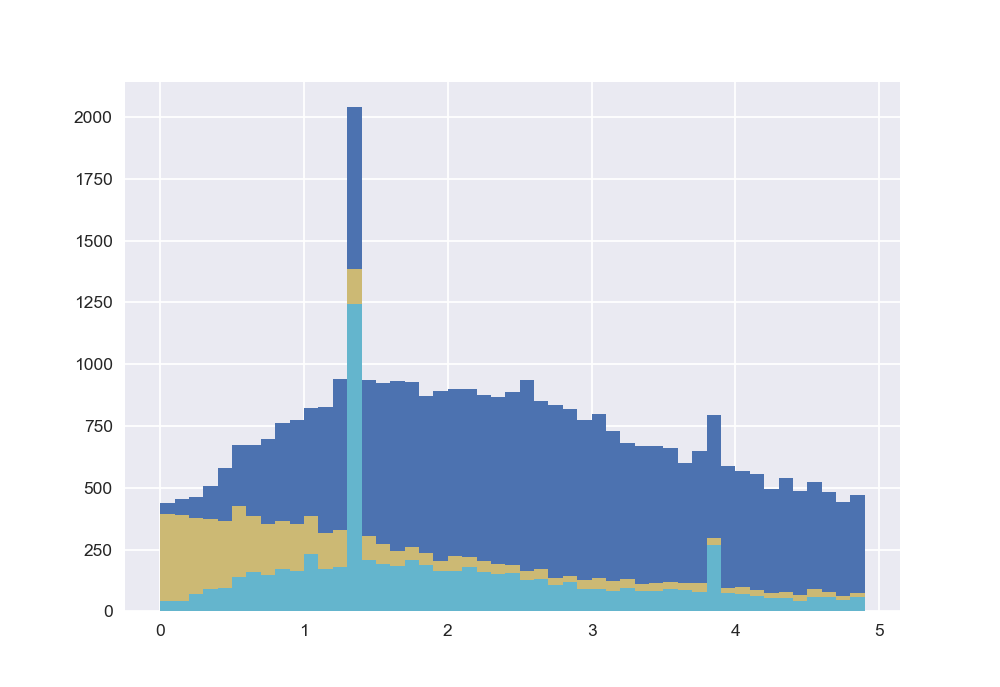

In [86]:
pd_visual["lid2"].hist(bins=np.arange(0,5,0.1))

In [91]:
pd_visual[reduce(lambda a, b: a | b, [(pd_visual.y_clean < 0).shift(-i) for i in range(5, 10)])] \
    ["lid2"].hist(bins=np.arange(0,5,0.1))

## Смотрим как сеть реагирует на входные данные

In [ ]:
(pd_visual.y_clean[200:] < 0).argmax()

In [ ]:
pd_visual.loc[265:285]

In [ ]:
from cars.utils import Action

In [ ]:
sensor_info = pd_visual.loc[273].values[:7]
rewards_to_controls_map = []
# дискретизируем множество значений, так как все возможные мы точно предсказать не сможем
for steering in np.linspace(-1, 1, 3):  # выбирать можно и другую частоту дискретизации, но
    for acceleration in np.linspace(-0.75, 0.75, 3):  # в наших тестах будет именно такая
        action = Action(steering, acceleration)
        agent_vector_representation = np.append(sensor_info, action)
        agent_vector_representation = agent_vector_representation.flatten()[:, np.newaxis]
        predicted_reward = float(agent_dbg.neural_net.feedforward(agent_vector_representation))
        rewards_to_controls_map.append((predicted_reward, action))

rewards_to_controls_map

In [ ]:
sorted(rewards_to_controls_map, key=lambda x: x[0])[-1]

In [ ]:
sensor_info = pd_visual.loc[275].values[:7]
rewards_to_controls_map = []
# дискретизируем множество значений, так как все возможные мы точно предсказать не сможем
for steering in np.linspace(-1, 1, 3):  # выбирать можно и другую частоту дискретизации, но
    for acceleration in np.linspace(-0.75, 0.75, 3):  # в наших тестах будет именно такая
        action = Action(steering, acceleration)
        agent_vector_representation = np.append(sensor_info, action)
        agent_vector_representation = agent_vector_representation.flatten()[:, np.newaxis]
        predicted_reward = float(agent_dbg.neural_net.feedforward(agent_vector_representation))
        rewards_to_controls_map.append((predicted_reward, action))

rewards_to_controls_map

In [ ]:
sorted(rewards_to_controls_map, key=lambda x: x[0])[-1]

In [ ]:
plt.ion()

In [ ]:
pd_visual[-8000:-6000].plot(y=["y_clean", "y_train", "y_predict"], figsize=(64, 4))

In [ ]:
rmse_before = ((pd_visual.y_train - pd_visual.y_predict)**2).mean() ** 0.5
rmse_before

In [ ]:
train_data = [(x[:, np.newaxis], y) for x, y in zip(X_train, y_train)]

In [ ]:
from learning_algorithms.network import Network
agent_dbg.neural_net = Network([9, 18, 8, 1], output_function=lambda x: x, output_derivative=lambda x: 1)

In [ ]:
epoch_num = 1
dyp_x = []
dyp_y = []

In [ ]:
plt.ion()
dyp = DynamicUpdate()
dyp.on_launch()

try:
    for res in agent_dbg.neural_net.SGD(
            training_data=train_data,
            epochs=500,
            mini_batch_size=50,
            eta=0.1,
            test_data=(X_train.T, y_train)):
        dyp_x.append(epoch_num)
        epoch_num += 1
        dyp_y.append(res)
        if epoch_num % 10 == 0:
            dyp.on_running(dyp_x, dyp_y)
except KeyboardInterrupt:
    print("min rmse: {}".format(min(dyp_y)))
print("min rmse: {}".format(min(dyp_y)))

In [ ]:

              epochs, mini_batch_size, eta, reward_shift, alpha):

    




    # evaluate
    w = create_map(seed=map_seed, agent=agent)
    mean_test_reward = w.evaluate_agent(agent, steps=tqdm_notebook(range(800), desc="test", leave=False), visual=False)
    log_message = f"""map_seed = {map_seed}
agent_random_action = {agent_random_action:.2f}
train_rmse = {train_rmse:.9f}
mean_train_revard = {mean_train_revard:.3f}
mean_test_reward  = {mean_test_reward:.3f}"""

    chart_count = agent.neural_net.num_layers
    plt.figure(figsize=(5 * chart_count, 2))
    for l in range(chart_count - 1):
        plt.subplot(1, chart_count, l+1)
        ax = sns.heatmap(agent.neural_net.weights[l])
        
    plt.subplot(1, chart_count, chart_count)    
    plt.text(0.05, 0.95, log_message, size=12, ha='left', va='top', family='monospace')
    
    plt.show()